# What is Machine Learning?

Let's say we want to find out how long an object takes to fall down from a certain height. We conduct an experiment from different heights (every 10cm) and obtain the following data:

In [1]:
# this command makes the plots interactive. If it doesn't work, comment it out.
%matplotlib ipympl


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read the data from csv and visualize the first three rows
falling_times = pd.read_csv("../data/ball_falling_time.csv")
falling_times.head(3)

,height,duration
0,0.0,0.000
1,0.2,0.175
2,0.4,0.311


Visualizing the data as a scatter plot, we see the following picture:

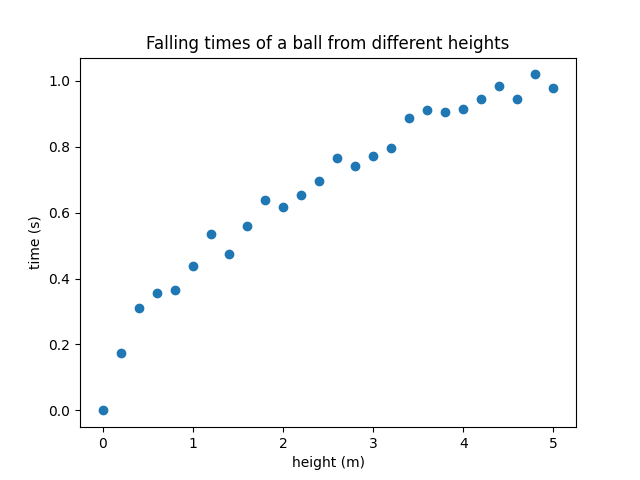

In [3]:
def plot_scatter(falling_times):
    plt.scatter(falling_times["height"], falling_times["duration"])
    plt.xlabel("height (m)")
    plt.ylabel("time (s)")

plt.figure()
plot_scatter(falling_times)
plt.title("Falling times of a ball from different heights");


## Classical Approach
A classical approach would be to formulate a hypothesis, and then validate this hypothesis using an experiment. Let's take the hypothesis that the distance travelled is proportional to the square of the time. If we plot the height against the time squared, we would expect a straight line.

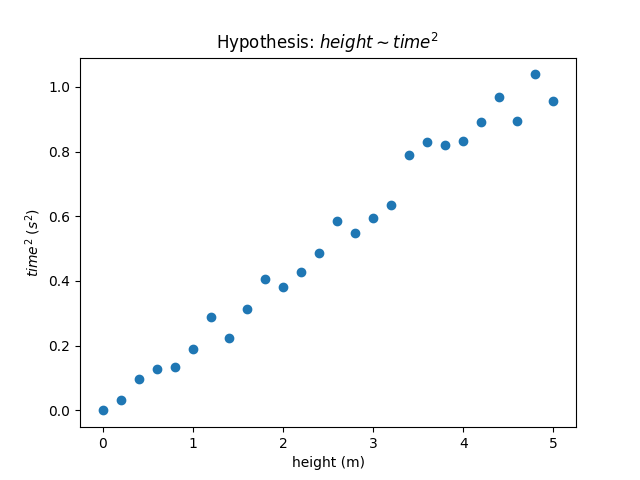

In [4]:
plt.figure()
plt.scatter(falling_times["height"], falling_times["duration"] ** 2)
plt.xlabel("height (m)")
plt.ylabel("$time^2$ ($s^2$)")
plt.title(r"Hypothesis: $height \sim time^2$");

Since all points are now on a straight line, we have validated the hypothesis that the height is proportional to the square of the time. We further observe that the slope is roughly 1/5th (for a height of 5m, we have $time^2 = 1s^2$), so we can deduce that 
$time^2 = \frac{1}{5} height$. If we pull the square root, we get <br> $time = \sqrt{\frac{1}{5} height}$. <br><br> This model now allows us to predict the falling time.

## Machine Learning Approach
Machine Learning also has the goal of predicting the falling times depending on the height. But: We do not care about where the model comes from, we just want a model that does a good job at predicting. In order to do this, we need a **dataset** of examples with falling times.

### Step 1: Formulating the Model Family

We have to specify the general form of the model - the so-called **model family**. For example, we can say that we expect the solution of the model to be of the form: <br>
$time = a * height^b$.

We do not know the values of $a$ and $b$ yet: We want to find the values of $a$ and $b$ that will best fit to our data. We call such values **parameters**.

In the Notebook cell below, play around with different values for a and b, until you find a combination that fits the data well.

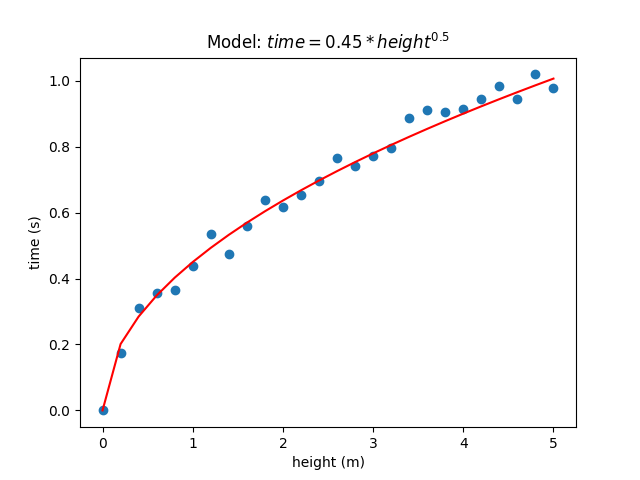

In [13]:
# CHANGE THIS
a = 0.45
b = .5

# don't change this
def predict(falling_times, a, b):
    return a * falling_times["height"] ** b

def plot_model(falling_times, predictions):
    plt.plot(falling_times["height"], predictions, c="red")

predictions = predict(falling_times, a, b)

plt.figure()
plot_scatter(falling_times)
plot_model(falling_times, predictions)
plt.title(r"Model: $time = {" + str(a) + r"} * height^{" + str(b) + r"}$");


### Step 2: Choosing the performance metric
Next, we have to decide how we measure the quality of our model - how do we know that a model is good after all? For example, we can measure the distance from our model predictions to the true data points, and calculate the average of that. 

A function that takes the true and the predicted values, and that then calculates how good we are, is called a **performance metric**. In our case, we will use the "mean absolute error" - the average distance from the predicted to the true points.

To visualize this, we need some helper functions...

In [14]:
def mean_absolute_error(true_values, predicted):
    """Function that calculates how much we are off on average."""
    return (true_values - predicted).abs().mean()

# no need to understand this
def plot_error_bars(falling_times, predictions):
    for predicted_time, true_time, height in zip(
        predictions,
        falling_times["duration"],
        falling_times["height"],
    ):
        plt.plot([height, height], [predicted_time, true_time], c="black")

def model_quality_plot(falling_times, a, b):
    predictions = predict(falling_times, a, b)
    plot_scatter(falling_times)
    plot_model(falling_times, predictions)
    plot_error_bars(falling_times, predictions)
    
    error = mean_absolute_error(falling_times["duration"], predictions)
    plt.title(f"Mean Absolute Error: {error:.3f}s")


With this performance metric we can now formulate an **objective**: We want to find the values $a$ and $b$ for which the performance metric is minimized.

Now, again play with the values of a and b to find the best possible model (with the lowest possible error). The error tells us by how much seconds we are wrong on average.

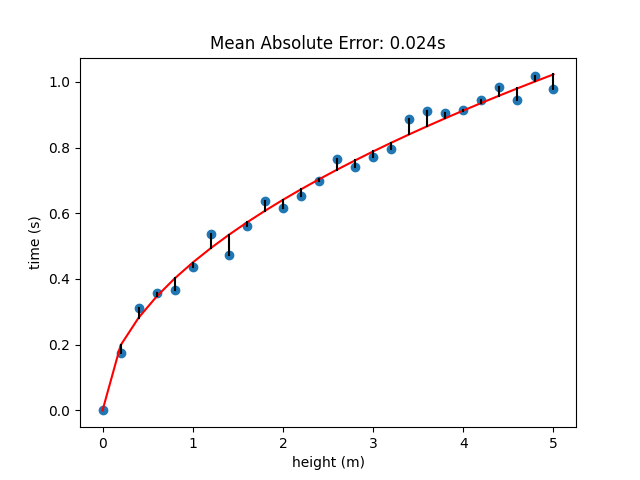

In [17]:
# CHANGE THIS
a = .45
b = .51

plt.figure()
model_quality_plot(falling_times, a, b)

### Step 3: Optimization

Instead of testing out different values ourselves, we can automate this procedure. Finding the best values for our parameters is called **model training**.

For example, we can test different combinations of $a$ and $b$ and calculate the error. We then keep the parameters that worked best - i.e. that gave us the smallest error. Such a procedure that finds the best values for $a$ and $b$ for us is called an **optimization algorithm**.

In [18]:
a_to_test = np.linspace(start=0, stop=1, num=51)
b_to_test = np.linspace(start=0, stop=1, num=51)

# results will be filled as a list of dictionaries
results = []
for a in a_to_test:
    for b in b_to_test:
        predictions = predict(falling_times, a, b)
        error = mean_absolute_error(falling_times["duration"], predictions)
        results.append(
            {
                "a": a,
                "b": b,
                "error": error,
            }
        )

# turn the list of dictionaries into a pandas DataFrame with three columns: a, b, and error
results_df = pd.DataFrame(results)

We can visualize the result as a heatmap:

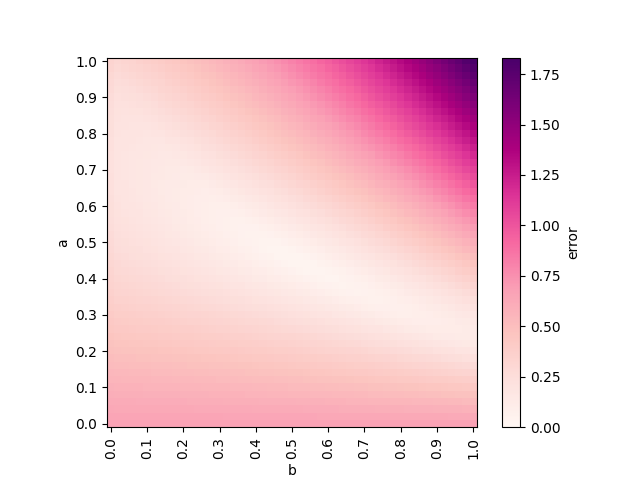

In [20]:
def plot_error_heatmap(error_df, rows="a", columns="b"):
    pivoted = error_df.pivot(index=rows, columns=columns)["error"]
    
    plt.imshow(pivoted, vmin=0, cmap="RdPu", origin="lower")
    plt.xticks(range(0, len(pivoted.columns), 5), np.round(pivoted.columns[::5], 1), rotation=90)
    plt.yticks(range(0, len(pivoted.index), 5), np.round(pivoted.index[::5], 1))

    plt.xlabel(columns)
    plt.ylabel(rows)

    cbar = plt.colorbar()
    cbar.set_label("error")

plt.figure()
plot_error_heatmap(results_df)

We can also visualize the result as a three-dimensional surface.

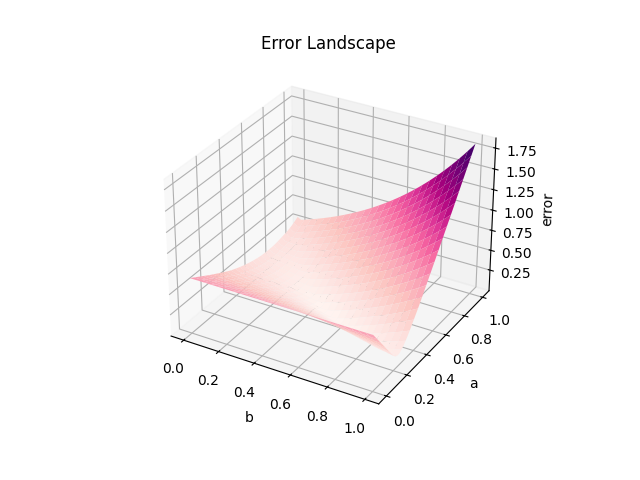

In [22]:
def plot_error_surface(error_df, rows="a", columns="b"):
    pivoted = error_df.pivot(index=rows, columns=columns)["error"]
    x, y = np.meshgrid(pivoted.columns, pivoted.index)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, pivoted.values, cmap="RdPu", vmin=0)

    ax.set_xlabel(columns)
    ax.set_ylabel(rows)
    ax.set_zlabel("error")
    ax.set_title("Error Landscape")

plot_error_surface(results_df)


Such a picture is called a **error landscape** (or sometimes loss landscape). It shows which combinations of $a$ and $b$ are good, and which are not so good. We can get the best values for $a$ and $b$ as follows:

In [23]:
best_result = results_df.sort_values("error").iloc[0]
best_result

a        0.440000
b        0.520000
error    0.024075
Name: 1148, dtype: float64

The best possible error that we could achieve is being off by 0.024 seconds, with a parameter of $a = 0.44$ and $b = 0.52$. This gives us a final model of the form:

$time = 0.44 * height^{0.52}$

If we plot the resulting model, we obtain the following picture:

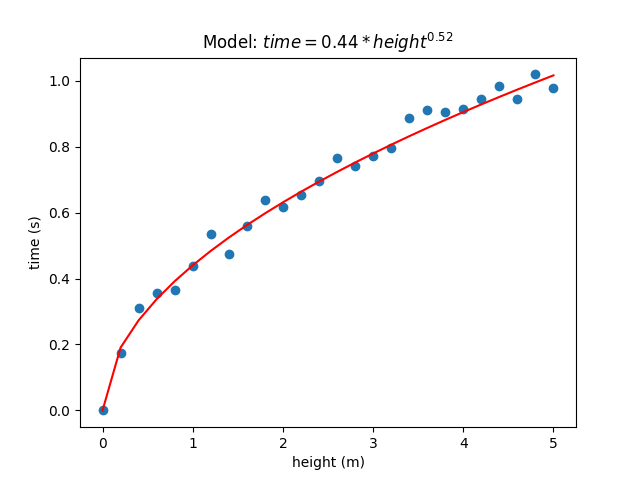

In [24]:

a = best_result["a"]
b = best_result["b"]
predictions = predict(falling_times, a, b)


plt.figure()
plot_scatter(falling_times)
plot_model(falling_times, predictions)
plt.title(r"Model: $time = {" + str(a) + r"} * height^{" + str(b) + r"}$");


We see that throught he machine learning approach, we have found a good model to predict the falling time of an object. 

## A Wrong Model Family
It is very important that we choose an appropriate model family - one, that can represent the true structure of our data. Another possibility would have been to model the data as:

$time = a * height + b$

Using this new model, try to find good values for $a$ and $b$.

In [25]:
def predict2(falling_times, a, b):
    return a * falling_times["height"] + b

def model_quality_plot2(falling_times, a, b):
    predictions = predict2(falling_times, a, b)
    plot_scatter(falling_times)
    plot_model(falling_times, predictions)
    plot_error_bars(falling_times, predictions)
    
    error = mean_absolute_error(falling_times["duration"], predictions)
    plt.title(f"Mean Absolute Error: {error:.3f}s")


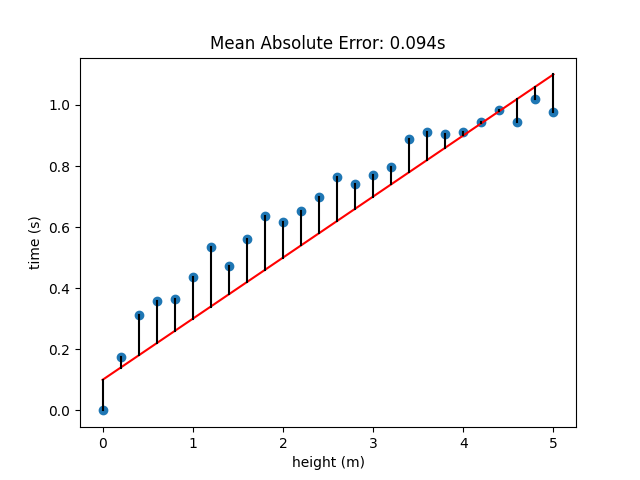

In [31]:
# CHANGE THIS
a = .2
b = 0.1

plt.figure()
model_quality_plot2(falling_times, a, b)

Let's find the best values for $a$ and $b$ using our optimization algorithm. 

In [32]:
a_to_test = np.linspace(start=0, stop=1, num=51)
b_to_test = np.linspace(start=0, stop=1, num=51)

# results will be filled as a list of dictionaries
results2 = []
for a in a_to_test:
    for b in b_to_test:
        predictions = predict2(falling_times, a, b)
        error = mean_absolute_error(falling_times["duration"], predictions)
        results2.append(
            {
                "a": a,
                "b": b,
                "error": error,
            }
        )

results_df2 = pd.DataFrame(results2)


The best model that we could achieve was the following:

In [33]:
best_result2 = results_df2.sort_values("error").iloc[0]
best_result2

a        0.160
b        0.280
error    0.047
Name: 422, dtype: float64

The error of the new best result is twice as high as with the previous model. The resulting fit looks like this:

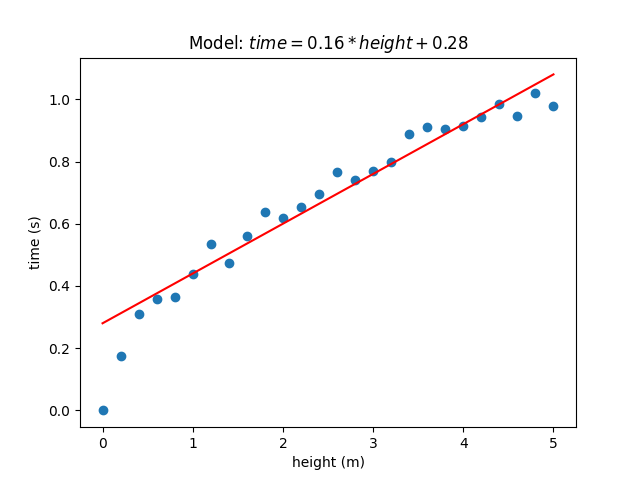

In [34]:
a = best_result2["a"]
b = best_result2["b"]
predictions = predict2(falling_times, a, b)

plt.figure()
plot_scatter(falling_times)
plot_model(falling_times, predictions)
plt.title(f"Model: $time = {a} * height + {b}$");


This shows that the quality of our fit very strongly depends on the model family that we choose. 


## Conclusion
This example has shown all key ingredients that are needed for a machine learning model.

- We need a dataset, on which we can train our model.
- We need to define a model family that will be used to fit our model. The model family has parameters, for which we want to find the best values.
- We need to define a performance metric and an objective: What to we want to optimize exactly?
- We need a optimization algorithm that finds the best parameter values for us.


## Exercises

### Exercise 1

Write down a definition for the following terms:
- **model family**:
- **parameter**:
- **performance metric**:
- **mean absolute error**:
- **objective**:
- **training**:
- **optimization algorithm**:
- **error landscape**:

### Exercise 2

According to Newton's second law, the distance travelled by an object without air resistance is given by:

$height = \frac{1}{2} g * time^2, \quad$ where $g = 9.81m/s^2$.

Solve this equation for $time$, and reformulate it to find the true values for $a$ and $b$, in the model family $time = a * height^b$. How close did we get to the true values with machine learning?

## Appendix
This is how the data is generated:

In [18]:
import numpy as np
import pandas as pd

noise_amount = .025
size = 25

height = np.linspace(.2, .2 * size, size)
true_duration = (2 * height / 9.81) ** (1/2)

# set the random seed such that this is reproducible
np.random.seed(123)
noise = np.random.normal(0, noise_amount, size=size)

df = pd.DataFrame(
    {
        "height": height,
        "duration": true_duration + noise,
    }
)

# add 0s for 0m
df.loc[-1] = [0, 0]

df.sort_index().to_csv("data/ball_falling_time.csv", index=False, float_format="%.3f")